In [1]:
import gymnasium as gym
import numpy as np
from stable_baselines3.common.env_util import make_vec_env
from copy import deepcopy
import torch
from torch.distributions import Normal
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.utils.data import Dataset, DataLoader
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv
import imageio
import pandas as pd
from tqdm import tqdm
from PIL import Image


In [2]:
!nvidia-smi

Mon Apr  1 04:44:23 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 545.23.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1080 Ti     On  | 00000000:01:00.0 Off |                  N/A |
|  0%   30C    P8              15W / 250W |      1MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
class CustomDataset(Dataset):
    def __init__(self, observations, actions):
        self.observations = torch.tensor(observations, dtype=torch.float32,device=device)
        self.actions = torch.tensor(actions, dtype=torch.float32,device=device)

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        observation = self.observations[idx]
        action = self.actions[idx]
        return observation, action

class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x))
        return x

    

Using device: cuda


In [4]:
env_id = "CartPole-v1"
# env = make_vec_env(env_id, n_envs=1)
# read /mnt/nfs/work/c98181/RL/dataset/CartPole-v1...npy
observations= np.load("/mnt/nfs/work/c98181/RL/dataset/CartPole-v1_1M_obs.npy", allow_pickle=True)
actions = np.load("/mnt/nfs/work/c98181/RL/dataset/CartPole-v1_1M_actions.npy", allow_pickle=True)
observations=observations.squeeze()
actions=actions.squeeze()
print(observations.shape[0], actions.shape[0])
print(observations[0], actions[0])

print(actions)

1000000 1000000
[-0.03013654  0.21001437 -0.04612853 -0.34675622] 1
[1 1 0 ... 0 1 1]


In [5]:
class mydataset(Dataset):
    def __init__(self, observations, actions):
        self.observations = torch.tensor(observations, dtype=torch.float32).to(device)
        self.actions = torch.tensor(actions, dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        observation = self.observations[idx]
        action = self.actions[idx]
        return observation, action

In [6]:
policy_network = PolicyNetwork(
    4, 2).to(device)


prev = PolicyNetwork(
    4, 2).to(device)


optimizer = torch.optim.Adam(policy_network.parameters(), lr=(1e-3))
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=1)


# Training loop
num_epochs = 300
batch_size = 512

dataset = mydataset(observations=observations, actions=actions)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

graph=[]
eval_rewards=[]
for epoch in range(num_epochs):
    policy_network.train()

    # Compute the log probabilities of the actions
    pbar=tqdm(dataloader,position=0,leave=True)
    loss_record=[]
    # step=0
    for step, (obs_batch,act_batch) in enumerate(pbar):
        # obs_batch = torch.tensor(np.array(obs_batch), dtype=torch.float32).to(device)
        # act_batch = torch.tensor(np.array(act_batch), dtype=torch.float32).to(device)
        if step % 100 == 0:
          prev.load_state_dict(policy_network.state_dict())
          prev.eval()
        # Get the log probabilities of the actions
        
        softmax = policy_network(obs_batch)
        # print(softmax.shape, act_batch.shape)
        model_act_sample = Categorical(softmax).sample()
        policy_chosen_logps = Categorical(softmax).log_prob(act_batch)
        policy_rejected_logps = Categorical(softmax).log_prob(model_act_sample)
        with torch.no_grad():
            reference_chosen_logps = Categorical(prev(obs_batch)).log_prob(act_batch)
            reference_rejected_logps = Categorical(prev(obs_batch)).log_prob(model_act_sample)
          

        pi_logratios = policy_chosen_logps - policy_rejected_logps
        ref_logratios = reference_chosen_logps - reference_rejected_logps

        # chosen_KL = (policy_chosen_logps - reference_chosen_logps).mean().clamp(min=0)
        # reject_KL = (policy_rejected_logps - reference_rejected_logps).mean().clamp(min=0)

        logits = pi_logratios - ref_logratios

        chosen_logratios = policy_chosen_logps - reference_chosen_logps
        reject_logratios = policy_rejected_logps - reference_rejected_logps

        # logits = chosen_logratios - reject_logratios

        if epoch <= 10:
          loss = - (policy_chosen_logps).mean()
        else:
          beta = 1
          losses = (
                  -F.logsigmoid(beta * logits)
              )
          # loss = losses.mean()
        #   losses = torch.cat((1 - F.logsigmoid(beta * (chosen_logratios - reject_KL)), 1 - F.logsigmoid(beta * (chosen_KL - reject_logratios))), 0)
          loss = losses.mean()
        # Optimize the policy
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()
        pbar.set_description((f"Epoch [{epoch+1}/{num_epochs}]"))
        positive_reward = chosen_logratios.detach().mean().item()
        negative_reward = reject_logratios.detach().mean().item()
        pbar.set_postfix({"loss":loss.detach().item(), "positive_reward": positive_reward, "negative_reward": negative_reward, "margin": positive_reward - negative_reward})


        #scheduler

        loss_record.append(loss.detach().item())
    scheduler.step()
    graph.append(sum(loss_record)/len(loss_record))

    policy_network.eval()  # 切换到评估模式

    env = make_vec_env(env_id, n_envs=1)

    state = env.reset()
    done = False
    total_reward=0
    # test the policy and save as gif
    frames = []
    while not done:
        state_tensor = torch.tensor([state], dtype=torch.float32).to(device)
        with torch.no_grad():
            action = Categorical(policy_network(state_tensor)).sample().cpu().numpy()[0]
            
        state, reward, done, _ = env.step(action)  # 执行动作
        total_reward += reward
        frame = env.render(mode="rgb_array")  # 获取当前环境的图像
        frames.append(frame)  # 添加到帧列表中

    # 保存为GIF
    image_path = f"cartpole_epoch_{epoch+1}.gif"
    imageio.mimsave("/mnt/nfs/work/c98181/RL/result/"+env_id+"/"+image_path, frames, duration=0.04)  # duration控制帧切换的速度


    env.close()
    print(total_reward)
    eval_rewards.append(total_reward)

  0%|          | 0/3907 [00:00<?, ?it/s]/tmp/ipykernel_497392/3279370013.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc3(x))
Epoch [1/300]: 100%|██████████| 3907/3907 [00:25<00:00, 151.73it/s, loss=0.131, positive_reward=0.0137, negative_reward=0.035, margin=-.0213]       
/tmp/ipykernel_497392/3886624399.py:97: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025847094/work/torch/csrc/utils/tensor_new.cpp:275.)
  state_tensor = torch.tensor([state], dtype=torch.float32).to(device)


[23.]


Epoch [2/300]:  51%|█████▏    | 2009/3907 [00:11<00:10, 173.73it/s, loss=0.118, positive_reward=0.00335, negative_reward=0.0114, margin=-.00803]    


KeyboardInterrupt: 

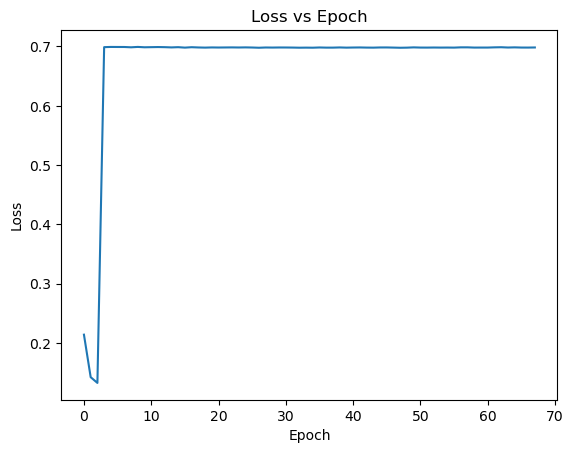

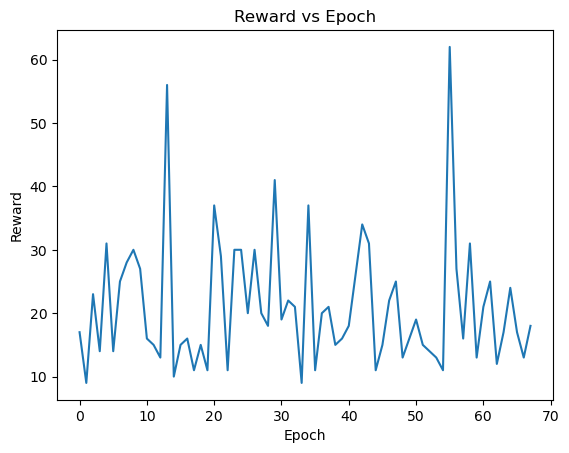

In [7]:
# draw the loss graph
import matplotlib.pyplot as plt
plt.plot(graph)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.show()

# draw the reward graph
plt.plot(eval_rewards)
plt.xlabel("Epoch")
plt.ylabel("Reward")
plt.title("Reward vs Epoch")
plt.show()

